# Измерительная система характеристик ударов в боевых искусствах

**Дано**:  

Пусть имеется датчик, закрепленный на запястье бойца, измеряющий линейные и угловые ускорения.  

В результате измерения имеется матрица $X$ размером $T \cdot F$,  
где $T$ - количество отсчетов измерений, сделанных с интервалом $dt = 1 ms$ (гиперпараметр),  
$F$ - количество измеряемых параметров (фич): $a_x, a_y, a_z$ - линейные ускорения по осям, $w_x, w_y, w_z$ - угловые ускорения.  



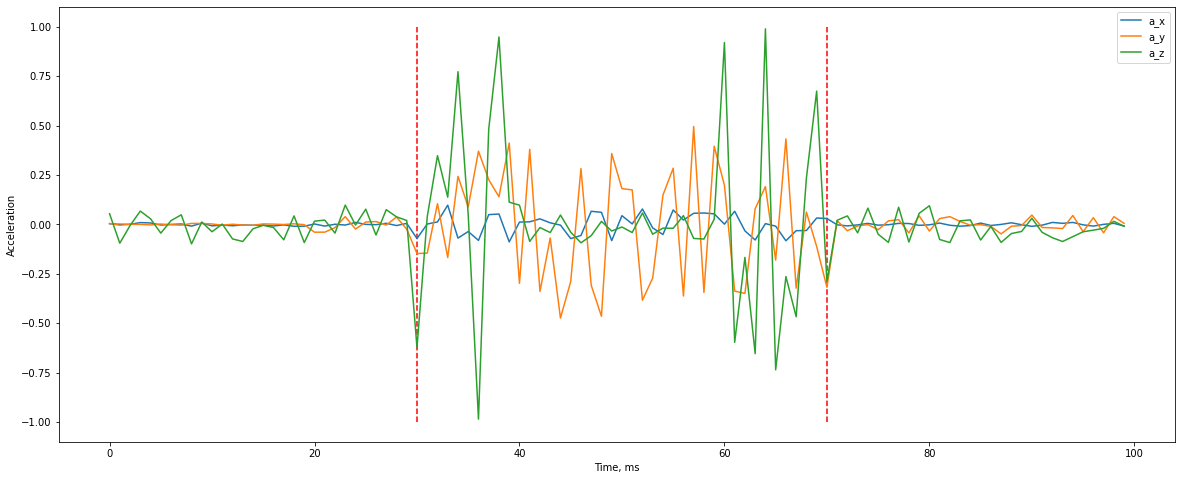

In [2]:
import numpy as np
import matplotlib.pyplot as plt
START, STOP = 30, 70
data = np.load('mock_data.npy')
plt.figure(figsize=(20, 8))
plt.xlabel('Time, ms')
plt.ylabel('Acceleration')
plt.vlines(START, -1, 1., linestyles='dashed', colors=('red'), label='start')
plt.vlines(STOP, -1, 1., linestyles='dashed', colors=('red'), label='stop')
plt.plot(np.arange(100), data)
plt.legend(['a_x', 'a_y', 'a_z'])
plt.show()

**Найти**:  

1) Индексы $start, stop$ - **начало и конец удара** соответственно - задача pattern recognition    

Пути решения:
- эвристики типа : начало удара - превышение ускорения по оси $y$ заданного значения, конец - 3 отсчета спустя пика отрицательного ускорения, соответствующего замедлению от удара в грушу. 
- алгоритмы свертки и корреляции
- более сложные алгоритмы pattern recognition (тоже на сверточных нейросетях)  

 2) **Класс удара** - ['Прямой', 'Хук', 'Аперкот' ...] - задача классификации   
 
Пути решения:  

 - деревья решений
 - логистическая классификация
 - линейная классификация
 - многослойные нейросети

3) **Качество удара** - скаляр или несколько значений: сила, скорость, правильность траектории и т.д. - задача регрессии  

Пути решения:
- линейная регрессия 
- многослойная нейросеть

Для обучения всех трех алгоритмов потребуется собрать и разметить данные, реализовать разные подходы и сравнить по метрикам:  

- IoU (intersection over union) - для задачи 1 (pattern recognition)  
- ROC AUC (area under curve) - интегральная метрика полноты и точности классификации (recall, precision) - для задачи 2  
- MSE (mean squared error) - вторая норма ошибки - для задачи 3  

Состав метрик тоже своего рода гиперпараметр, можно поэкспериментировать и выяснить какие показатели будут лучше работать.

Т.о. для разметки данных помимо датчика и устройства сбора понадобятся средство измерения силы удара - макивара с датчиком давления, и эксперт (тренер) для оценки правильности траектории - каждому удару необходимо будет проставить оценку от 1 до 5.  

Кроме того, скорее всего нужно будет по-разному оценивать два режима работы бойца: "бой с грушей" и "бой с тенью".

Использование видеопотока для решения задач захвата, классификации и оценки качества удара, на мой взгляд, затруднено двумя обстоятельствами:  

1. Обычная камера снимает с частототой около 20 Гц, т.е. интервал измерения - 50 мс. Для удара длительностью 200 мс это будет всего 4 измерения. Применение высокочастотной камеры увеличит стоимость конечного устройства.   

2. Количество признаков равно $W \cdot H \cdot C$, для стандартного изображения 640 х 480 - это  921600 признаков. Только выделение  ключевых точек на таком изображении требует около 30 мс на процессоре типа intel i3 7100. Сответственно, в режиме реального времени нужен будет сопроцессор GPU (TPU), что тоже увеличит стоимость системы. А хотелось бы решение, способное работать на CPU мобильного телефона. 

<img src="PMS.jpg" width=480>

Для решения этих задач предлагается разработать измерительную систему на базе измерительных модулей T-Wristband (ESP32 + MPU9250) с обработкой результатов в мобильном приложении.  

Алгоритм работы:  
1. На экране телефона загорается один из индикаторов, соответствующий классу удара, который необходимо нанести (дублируется вибромодулем). Фиксируется момент времени $t_0$
2. Боец наносит соответствующий удар (по воздуху или по груше). Фиксируются моменты начала и окончания удара $t_1, t_2$ (Задача 1).
3. Определяется класс удара (Задача 2) и определяется, правильный ли удар был произведен. 
4. Определяется качество удара (Задача 3): задержка реакции $t_1 - t_0$, время самого удара $t_2 - t_1$, сила удара и правильность траектории.
5. На экран выводится информация о качестве произведенного удара.  
6. Логгирование результатов в базу данных, что позволит в будущем анализировать динамику тренировок и сравнивать характеристики разных бойцов. 
7. goto 1.

В режиме сбора данных при отработке ударов должен присутствовать тренер, который сможет поставить оценку, насколько правильно был произведен удар. При наличии макивары с датчиком давления также измеряется сила удара. Сбор этих данных позволит обучить регрессоры и в дальнейшем обходиться без помощи тренера и макивары.